In [8]:
# =====================================================
# IMPORTS
# =====================================================
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
import time
import itertools
import gc

# =====================================================
# 1. Monter Google Drive
# =====================================================
from google.colab import drive
drive.mount('/content/drive')

# =====================================================
# 2. Charger le dataset depuis Drive
# =====================================================
path = '/content/drive/MyDrive/merged_feature_balanced.csv'  # adapte le chemin si nécessaire
df = pd.read_csv(path)
print("Shape:", df.shape)
print(df.head())

X = df.drop(columns=['class']).values
y = df['class'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================================================
# 3. Fonctions utilitaires vectorisées
# =====================================================
def gini(y):
    if len(y) == 0:
        return 0
    counts = np.bincount(y)
    prob = counts / len(y)
    return 1.0 - np.sum(prob**2)

def best_split_vectorized(X, y, num_thresholds=10, min_samples_split=2):
    m, n_features = X.shape
    best_gain = -1
    best_feature, best_thresh = None, None
    parent_gini = gini(y)

    for feature in range(n_features):
        thresholds = np.quantile(X[:, feature], np.linspace(0,1,num_thresholds+2)[1:-1])
        for thresh in thresholds:
            left_mask = X[:, feature] <= thresh
            right_mask = ~left_mask
            if left_mask.sum() < min_samples_split or right_mask.sum() < min_samples_split:
                continue
            gini_left = gini(y[left_mask])
            gini_right = gini(y[right_mask])
            gain = parent_gini - (left_mask.sum()/m)*gini_left - (right_mask.sum()/m)*gini_right
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = thresh
    return best_feature, best_thresh, best_gain

class Node:
    def __init__(self, feature=None, thresh=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.thresh = thresh
        self.left = left
        self.right = right
        self.value = value

def build_tree_vectorized(X, y, depth=0, max_depth=8, num_thresholds=10,
                          min_samples_split=2, min_samples_leaf=1):
    n_samples = len(y)
    if (depth >= max_depth or n_samples < min_samples_split or len(np.unique(y)) == 1):
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    feature, thresh, gain = best_split_vectorized(X, y, num_thresholds, min_samples_split)
    if gain is None or gain <= 0:
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    left_mask = X[:, feature] <= thresh
    right_mask = ~left_mask
    if left_mask.sum() < min_samples_leaf or right_mask.sum() < min_samples_leaf:
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    left = build_tree_vectorized(X[left_mask], y[left_mask], depth+1, max_depth,
                                 num_thresholds, min_samples_split, min_samples_leaf)
    right = build_tree_vectorized(X[right_mask], y[right_mask], depth+1, max_depth,
                                  num_thresholds, min_samples_split, min_samples_leaf)
    return Node(feature=feature, thresh=thresh, left=left, right=right)

def predict_one(node, x):
    while node.value is None:
        if x[node.feature] <= node.thresh:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(tree, X):
    return np.array([predict_one(tree, xi) for xi in X])

# =====================================================
# 4. Configurations à tester (81 modèles)
# =====================================================
max_depth_list = [6, 8, 10]
num_thresholds_list = [10, 20, 30]
min_samples_split_list = [5, 10, 15]
min_samples_leaf_list = [2, 5, 8]

configs = list(itertools.product(max_depth_list,
                                 num_thresholds_list,
                                 min_samples_split_list,
                                 min_samples_leaf_list))

results_file = '/content/drive/MyDrive/decision_tree_results_full.csv'
results = []

# =====================================================
# 5. Boucle batch sécurisée + sauvegarde partielle
# =====================================================
for i, (max_depth, num_thresholds, min_samples_split, min_samples_leaf) in enumerate(configs):
    print(f"\n=== Configuration {i+1}/{len(configs)}: max_depth={max_depth}, num_thresholds={num_thresholds}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf} ===")
    start_time = time.time()

    tree = build_tree_vectorized(X_train, y_train,
                                 max_depth=max_depth,
                                 num_thresholds=num_thresholds,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf)

    train_time = time.time() - start_time
    y_pred = predict(tree, X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    results.append({
        "max_depth": max_depth,
        "num_thresholds": num_thresholds,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "train_time_sec": train_time,
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision
    })

    # Sauvegarde partielle
    pd.DataFrame(results).to_csv(results_file, index=False)
    print(f"✅ Résultats sauvegardés dans {results_file}")

    # Libération mémoire
    del tree
    gc.collect()

# =====================================================
# 6. Tableau final récapitulatif
# =====================================================
df_results = pd.DataFrame(results)
print("\n=== Résultats finaux ===")
print(df_results)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (223751, 16)
   latitude  longitude   TEB_log  CEC_CLAY  GYPSUM_log  TEXTURE_SOTER_encoded  \
0  1.599941   0.424514 -0.873085 -0.186051   -0.359351               0.414534   
1  1.008210  -0.100769  0.326187 -0.472797    0.205265               0.414534   
2  0.890917   0.214921  0.326187 -0.472797    0.205265               0.414534   
3 -1.445041  -0.234935  0.326187  0.846235   -0.204527               0.414534   
4 -1.360532  -0.229133  0.326187  0.846235   -0.204527               0.414534   

   ORG_CARBON_log  LCCCODE_encoded  ELEC_COND_log    COARSE  \
0        0.923640        -1.239120      -0.436378  0.537499   
1        0.430136        -1.002590       0.023074 -0.631298   
2        0.430136         0.534857       0.023074 -0.631298   
3        0.153275         0.771388       0.428338 -1.020897   
4        0.153275        -1.002590       0.428338

In [1]:
# =====================================================
# IMPORTS
# =====================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
import itertools
import time

# =====================================================
# 1. Charger le dataset depuis local
# =====================================================
df = pd.read_csv(r"C:\Users\pc\Desktop\DM\datasets\merged_feature_balanced.csv")
print("Shape:", df.shape)
print(df.head())

X = df.drop(columns=['class']).values
y = df['class'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================================================
# 2. Configurations à tester (81 modèles)
# =====================================================
max_depth_list = [6, 8, 10]
num_thresholds_list = [10, 20, 30]  
min_samples_split_list = [5, 10, 15]
min_samples_leaf_list = [2, 5, 8]

configs = list(itertools.product(max_depth_list,
                                 num_thresholds_list,
                                 min_samples_split_list,
                                 min_samples_leaf_list))

results_file = r"C:\Users\pc\Desktop\DM\results\decision_tree_results_sklearn.csv"
results = []

# =====================================================
# 3. Boucle pour tester chaque configuration
# =====================================================
for i, (max_depth, max_features, min_samples_split, min_samples_leaf) in enumerate(configs):
    print(f"\n=== Configuration {i+1}/{len(configs)} ===")
    print(f"max_depth={max_depth}, max_features={max_features}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
    
    start_time = time.time()
    
    # Créer et entraîner le modèle
    clf = DecisionTreeClassifier(max_depth=max_depth,
                                 max_features=None, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=42)
    clf.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    # Prédiction sur le test
    y_pred = clf.predict(X_test)
    
    # Mesures
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Ajouter aux résultats
    results.append({
        "max_depth": max_depth,
        "max_features": max_features,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "train_time_sec": train_time,
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision
    })
    
    # Sauvegarde partielle
    pd.DataFrame(results).to_csv(results_file, index=False)
    print(f"✅ Résultats sauvegardés dans {results_file}")

# =====================================================
# 4. Résultats finaux
# =====================================================
df_results = pd.DataFrame(results)
print("\n=== Résultats finaux ===")
print(df_results)


Shape: (223751, 16)
   latitude  longitude   TEB_log  CEC_CLAY  GYPSUM_log  TEXTURE_SOTER_encoded  \
0  1.599941   0.424514 -0.873085 -0.186051   -0.359351               0.414534   
1  1.008210  -0.100769  0.326187 -0.472797    0.205265               0.414534   
2  0.890917   0.214921  0.326187 -0.472797    0.205265               0.414534   
3 -1.445041  -0.234935  0.326187  0.846235   -0.204527               0.414534   
4 -1.360532  -0.229133  0.326187  0.846235   -0.204527               0.414534   

   ORG_CARBON_log  LCCCODE_encoded  ELEC_COND_log    COARSE  \
0        0.923640        -1.239120      -0.436378  0.537499   
1        0.430136        -1.002590       0.023074 -0.631298   
2        0.430136         0.534857       0.023074 -0.631298   
3        0.153275         0.771388       0.428338 -1.020897   
4        0.153275        -1.002590       0.428338 -1.020897   

   TEXTURE_USDA_encoded      prec  elevation_scaled     tmean    trange  class  
0              0.737545  3.782619

=== FromScratch ===
   max_depth  num_thresholds  min_samples_split  min_samples_leaf  \
0          6              10                  5                 2   
1          6              10                  5                 5   
2          6              10                  5                 8   
3          6              10                 10                 2   
4          6              10                 10                 5   

   train_time_sec  accuracy  f1_score  precision  
0        5.444144  0.810082  0.808735   0.818929  
1        5.715420  0.810082  0.808735   0.818929  
2        5.854838  0.810038  0.808688   0.818893  
3        5.264104  0.810038  0.808688   0.818893  
4        6.271309  0.810038  0.808688   0.818893  

=== Sklearn ===
   max_depth  max_features  min_samples_split  min_samples_leaf  \
0          6            10                  5                 2   
1          6            10                  5                 5   
2          6            10               

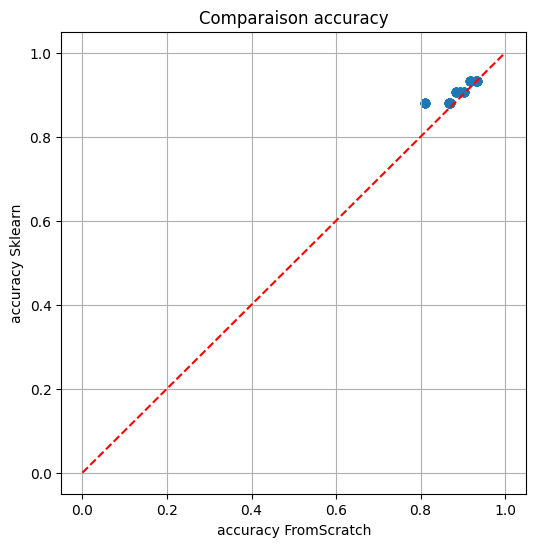

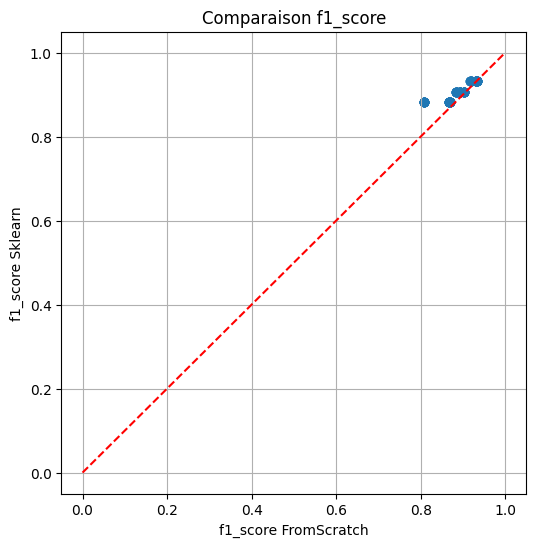

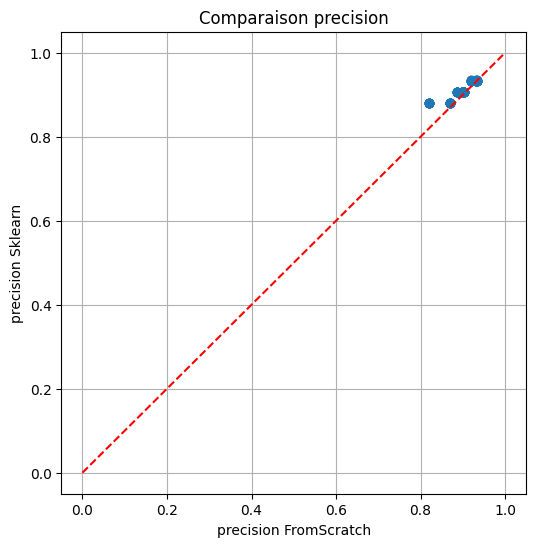


Différence moyenne pour accuracy: -0.0171
Différence maximale pour accuracy: 0.0000
Différence minimale pour accuracy: -0.0713

Différence moyenne pour f1_score: -0.0173
Différence maximale pour f1_score: 0.0001
Différence minimale pour f1_score: -0.0726

Différence moyenne pour precision: -0.0155
Différence maximale pour precision: -0.0002
Différence minimale pour precision: -0.0625


In [4]:
# =====================================================
# IMPORTS
# =====================================================
import pandas as pd
import matplotlib.pyplot as plt

# =====================================================
# 1. Charger les fichiers CSV
# =====================================================
df_from_scratch = pd.read_csv(r"C:\Users\pc\Desktop\DM\results\decision_tree_results_from_scratch.csv")
df_sklearn = pd.read_csv(r"C:\Users\pc\Desktop\DM\results\decision_tree_results_sklearn.csv")

# Aperçu
print("=== FromScratch ===")
print(df_from_scratch.head())
print("\n=== Sklearn ===")
print(df_sklearn.head())

# =====================================================
# 2. Moyennes et écarts-types
# =====================================================
metrics = ['accuracy', 'f1_score', 'precision']

print("\n=== Moyennes FromScratch ===")
print(df_from_scratch[metrics].mean())
print("\n=== Moyennes Sklearn ===")
print(df_sklearn[metrics].mean())

print("\n=== Écarts-types FromScratch ===")
print(df_from_scratch[metrics].std())
print("\n=== Écarts-types Sklearn ===")
print(df_sklearn[metrics].std())

# =====================================================
# 3. Scatter plots pour comparer
# =====================================================
for metric in metrics:
    plt.figure(figsize=(6,6))
    plt.scatter(df_from_scratch[metric], df_sklearn[metric])
    plt.xlabel(f"{metric} FromScratch")
    plt.ylabel(f"{metric} Sklearn")
    plt.title(f"Comparaison {metric}")
    plt.plot([0,1],[0,1], 'r--')  # ligne y=x
    plt.grid(True)
    plt.show()


# =====================================================
# 5. Différences moyennes
# =====================================================
for metric in metrics:
    diff = df_from_scratch[metric] - df_sklearn[metric]
    print(f"\nDifférence moyenne pour {metric}: {diff.mean():.4f}")
    print(f"Différence maximale pour {metric}: {diff.max():.4f}")
    print(f"Différence minimale pour {metric}: {diff.min():.4f}")
